# 首先来一起看一下矢量乘法和标量乘法的差距

ps：对比这个差距主要是为了后面实现的线性回归模型是基于矢量乘法的基础下

In [0]:
import torch
import time

n = 1000
a = torch.ones(n)
b = torch.ones(n)

In [0]:
# 定义一个计时的类
class Timer(object):
    """Record multiple running times."""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        # start the timer
        self.start_time = time.time()

    def stop(self):
        # stop the timer and record time into a list
        self.times.append(time.time() - self.start_time)
        return self.times[-1]

    def avg(self):
        # calculate the average and return
        return sum(self.times)/len(self.times)

    def sum(self):
        # return the sum of recorded time
        return sum(self.times)

# 对比
根据以下两段代码的对比结果，可以看出来，明显矢量

In [3]:
timer = Timer()
c = torch.zeros(n)
for i in range(n):
    c[i] = b[i] + a[i]
'%.5f sec' % timer.stop()

'0.03816 sec'

In [4]:
timer = Timer()
c = a + b
'%.5f sec' % timer.stop()

'0.00084 sec'

# 基于pytorch实现一个简单的线性回归

In [5]:
# import packages and modules
%matplotlib inline
import torch
from IPython import display
from matplotlib import pyplot as plt
import numpy as np
import random

print(torch.__version__)

1.4.0


In [0]:
# 生成数据
num_input = 2
num_examples = 1000

true_w = [2, -3.1]
true_b = 3.7

features = torch.randn(num_examples, num_input, dtype=torch.float32)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b

# 加一点噪音
labels += torch.tensor(np.random.normal(0, 0.01, size=num_examples), dtype=torch.float32)

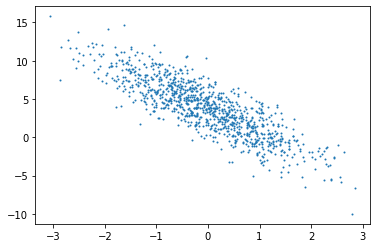

In [7]:
# 可视化数据

plt.scatter(features[:, 1].numpy(), labels.numpy(), 1)

In [0]:
# 定义一个迭代器读取数据集
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    idx = list(range(num_examples))
    random.shuffle(idx)
    for i in range(0, num_examples, batch_size):
        j = torch.LongTensor(idx[i: min(i + batch_size, num_examples)])
        yield features.index_select(0, j), labels.index_select(0, j)

In [9]:
batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 2.1132, -0.4458],
        [-0.3706, -0.2687],
        [ 0.2025, -0.9047],
        [-0.0149,  0.5977],
        [-0.3376, -0.2409],
        [ 1.0565,  1.0533],
        [ 0.5366,  0.1297],
        [-1.4190,  1.0554],
        [ 1.7250, -1.4916],
        [ 0.2860,  1.5530]]) 
 tensor([ 9.3088,  3.7924,  6.8969,  1.8071,  3.7653,  2.5450,  4.3862, -2.4187,
        11.7901, -0.5525])


In [10]:
# 初始化模型参数

w = torch.tensor(np.random.normal(0, 0.01, (num_input, 1)), dtype=torch.float32)
b = torch.zeros(1, dtype=torch.float32)

# 设定需要求梯度
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True)

tensor([0.], requires_grad=True)

In [0]:
# 定义线性回归模型

def linreg(X, w, b):
    return torch.mm(X, w) + b

In [0]:
# 定义一下损失函数，这里使用的是平方差损失函数
def squared_loss(y_hat, y):
    # view 函数相当于reshape函数
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

In [0]:
# 定义一下优化函数，这里使用的是随机梯度下降
def sgd(params, lr, batch_size):
    for param in params:
        param.data -= lr * param.grad / batch_size

In [19]:
# 训练
lr = 0.03
num_epochs = 5

net = linreg
loss = squared_loss

# trainning
for epoch in range(num_epochs):
    # 利用数据迭代器产生数据
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y).sum()
        # 计算梯度
        l.backward()
        # sgd更新参数
        sgd([w, b], lr, batch_size)
        # 复位参数的梯度
        w.grad.data.zero_()
        b.grad.data.zero_()

    train_l = loss(net(features, w, b), labels)
    print('epoch %d loss %f' % (epoch + 1, train_l.mean().item()))

epoch 1 loss 0.385244
epoch 2 loss 0.000914
epoch 3 loss 0.000053
epoch 4 loss 0.000050
epoch 5 loss 0.000050


# 小小的总结
至此，完成了一个简单版的线性回归模型，总结有以下步骤：
- 生成数据
- 定义数据迭代器
- 构建线性回归模型
- 构建参数w、b
- 构建损失函数
- 构建随机梯度下降函数
- 拟合模型

In [22]:
w, true_w, b, true_b

(tensor([[ 2.0001],
         [-3.0997]], requires_grad=True),
 [2, -3.1],
 tensor([3.6997], requires_grad=True),
 3.7)

# 线性回归模型使用pytorch简洁实现

In [23]:
import torch
from torch import nn
import numpy as np
torch.manual_seed(1)

print(torch.__version__)
torch.set_default_tensor_type('torch.FloatTensor')

1.4.0


In [0]:
# 生成数据集
num_examples = 1000

true_w = [2, -3.4]
true_b = 4.2

features = torch.tensor(np.random.normal(0, 1, (num_examples, num_input)), dtype=torch.float)
labels = true_w[0] * features[:, 0] + true_w[1] * features[:, 1] + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)

In [0]:
import torch.utils.data as Data

batch_size = 10

dataset = Data.TensorDataset(features, labels)

data_iter = Data.DataLoader(
    dataset=dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

In [31]:
# 测试一下迭代器
for X, y in data_iter:
    print(X, '\n', y)
    break

tensor([[-0.3192, -1.3295],
        [-1.8234,  0.1823],
        [ 0.8812, -1.2254],
        [ 0.8714,  0.1576],
        [-0.3909, -0.7122],
        [ 1.2736, -0.5050],
        [-0.8517, -0.2477],
        [-1.1181, -1.4391],
        [-0.3291, -1.2563],
        [ 1.6908,  1.8148]]) 
 tensor([ 8.0775, -0.0680, 10.1391,  5.4192,  5.8365,  8.4490,  3.3449,  6.8574,
         7.8132,  1.3959])


In [34]:
# 定义模型
class LinearNet(nn.Module):
    def __init__(self, n_feature):
        """
        n_feature: 表示特征的数量
        """
        # 调用父类进行初始化
        super(LinearNet, self).__init__()
        self.linear = nn.Linear(n_feature, 1)

    def forward(self, x):
        y = self.linear(x)
        return y

net = LinearNet(num_input)
print(net)

LinearNet(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)


In [36]:
# 几种把网络串联起来的方法，和keras里面的类似
net = nn.Sequential(
   nn.Linear(num_input, 1) 
)

net = nn.Sequential()
net.add_module('linear', nn.Linear(num_input, 1))

from collections import OrderedDict
net = nn.Sequential(
    OrderedDict(
        [
         ('linear', nn.Linear(num_input, 1))
        ]
    )
)
print(net)
print(net[0])

Sequential(
  (linear): Linear(in_features=2, out_features=1, bias=True)
)
Linear(in_features=2, out_features=1, bias=True)


In [38]:
# 初始化模型参数
from torch.nn import init

# 初始化一个正太分布
init.normal_(net[0].weight, mean=0.0, std=0.01)
# 初始化一个常数
init.constant_(net[0].bias, val=0.0)

Parameter containing:
tensor([0.], requires_grad=True)

In [40]:
# 查看一下初始化的参数
for param in net.parameters():
    print(param)

Parameter containing:
tensor([[-0.0046,  0.0067]], requires_grad=True)
Parameter containing:
tensor([0.], requires_grad=True)


In [0]:
# 定义损失函数
loss = nn.MSELoss()

In [43]:
# 定义优化函数
import torch.optim as optim

optimizer = optim.SGD(net.parameters(), lr=0.03)
print(optimizer)

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.03
    momentum: 0
    nesterov: False
    weight_decay: 0
)


In [44]:
# 训练
num_epochs = 3
for epoch in range(1, num_epochs + 1):
    for X, y in data_iter:
        output = net(X)
        l = loss(output, y.view(-1, 1))
        # 恢复梯度
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
    print('epoch %d, loss: %f' % (epoch, l.item()))

epoch 1, loss: 0.000191
epoch 2, loss: 0.000067
epoch 3, loss: 0.000191


In [45]:
dense = net[0]
print(true_w, dense.weight.data)
print(true_b, dense.bias.data)

[2, -3.4] tensor([[ 1.9994, -3.3990]])
4.2 tensor([4.1993])
